In [1]:
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionDiffEditPipeline, DDIMScheduler, DDIMInverseScheduler

/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
dataset = CIFAR10(root="~/.cache", download=True)

full_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified


In [3]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [243]:
from abc import ABC, abstractmethod  #, property
from typing import Callable, List, Optional


class ImageEditor(ABC):

    # @property
    # @abstractmethod
    # def original_prompt(self) -> str:
    #     pass

    # @original_prompt.setter
    # @abstractmethod
    # def original_prompt(self, val):
    #     self.original_prompt = val
    
    # @abstractmethod
    # def edit(
    #     self,
    #     image: Image.Image,
    #     target_prompts: List[str],

    pass


class PromptTemplate:

    def __init__(self, format_str: str):
        if "{sub}" not in format_str:
            raise ValueError("{sub} not found in format_str")
        self.format_str = format_str

    def substitute(self, substitution: str):
        return self.format_str.format(sub=substitution)


class SDEdit(ImageEditor):

    def __init__(self, target_prompt_template: PromptTemplate, device: torch.device, dtype: torch.dtype):
        self.preprocess = transforms.Compose(
            [
                transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.model = StableDiffusionImg2ImgPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=dtype,
            safety_checker=None,
        ).to(device)
        self.model.set_progress_bar_config(disable=True)
        
        self.target_prompt_template = target_prompt_template

    def edit(self, image: Image.Image, target_prompt_substitutes: List[str], **model_kwargs) -> np.array:
        return self.model(
            prompt=[self.target_prompt_template.substitute(s) for s in target_prompt_substitutes],
            image=self.preprocess(image),
            generator=model_kwargs["generator"],
            strength=model_kwargs["strength"],
            num_inference_steps=model_kwargs["num_inference_steps"],
            output_type="np.array",
        ).images
        

class DiffuserCallback:

    def __init__(self):
        self.steps = []
        self.timesteps = []
        self.latents = []

    def plot_timesteps(self, timesteps: List[int]):
        rows = len(timesteps)
        if rows <= 1:
            raise ValueError(f"Cannot produce plot of {rows} timesteps stored in callback")
        fig, axes = plt.subplots(nrows=rows, ncols=1)
        for t, ax in zip(timesteps, axes):
            ax.set_title(str(t))
            idx = self.timesteps.index(t)
            latent = self.latents[idx]
            ax.imshow(latent)
        plt.show()

    def __call__(self, step_idx: torch.IntTensor, timestep: torch.IntTensor, latent: torch.FloatTensor):
        self.steps.append(int(step_idx))
        self.timesteps.append(int(timestep))
        self.latents.append(latent.cpu().squeeze(0).permute(1, 2, 0).numpy())


class DiffuserCallbackFactory:

    def __init__(self):
        self.callback_factory = {}

    def generate_callback(self, name: str) -> DiffuserCallback:
        callback = DiffuserCallback()
        self.callback_factory[name] = callback
        return callback

    def get_callback(self, name: str) -> DiffuserCallback:
        return self.callback_factory[name]


class DiffEdit(ImageEditor):

    def __init__(self, source_prompt: str, target_prompt_template: PromptTemplate, device: torch.device, dtype: torch.dtype):
        self.preprocess = transforms.Compose(
            [
                transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.model = StableDiffusionDiffEditPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=dtype,
            safety_checker=None,
        ).to(device)
        self.model.scheduler = DDIMScheduler.from_config(self.model.config)
        self.model.inverse_scheduler = DDIMInverseScheduler.from_config(self.model.config)
        self.model.enable_model_cpu_offload()
        # self.model.set_progress_bar_config(disable=True)
        
        self.source_prompt = source_prompt
        self.target_prompt_template = target_prompt_template

    def edit(
        self,
        image: Image.Image,
        target_prompt_substitutes: List[str],
        num_inference_steps: int,
        guidance_scale: float,
        strength: float,
        generator: Optional[torch.Generator] = None,
        callback_factory: Optional[DiffuserCallbackFactory] = None,
        callback_steps: int = 1,
    ) -> np.array:
        edited_images = []
        # image = self.preprocess(image)
        for t in target_prompt_substitutes:
            target_prompt = self.target_prompt_template.substitute(t)
            callback = None if callback_factory is None else callback_factory.generate_callback(t)
            mask_image = self.model.generate_mask(
                image=image,
                source_prompt=self.source_prompt,
                target_prompt=target_prompt,
                num_inference_steps=100,  # num_inference_steps,
                generator=generator,
            )
            image_latents = self.model.invert(
                image=image,
                prompt=self.source_prompt,
                inpaint_strength=strength,
                num_inference_steps=80,  # num_inference_steps,
                generator=generator,
            ).latents
            edited_image = self.model(
                mask_image=mask_image,
                prompt=target_prompt,
                image_latents=image_latents,
                guidance_scale=guidance_scale,
                inpaint_strength=strength,
                num_inference_steps=80,  # num_inference_steps,
                generator=generator,
                callback=callback,
                callback_steps=callback_steps,
            ).images[0]
            edited_images.append(edited_image)
        return np.stack(edited_images)

In [244]:
device = torch.device("cuda")
dtype = torch.float16
g = torch.Generator(device="cpu").manual_seed(42)

prompt_template = PromptTemplate("A photo of an {sub}")

In [245]:
labels = [
    # "airplane",
    # "automobile",
    # "bird",
    "cat",
    # "deer",
    "dog",
    # "frog",
    # "horse",
    # "ship",
    # "truck",
]

In [246]:
# sdedit = SDEdit(prompt_template, device, dtype)
# edited_images = sdedit.edit(
#     dataset[3][0],
#     ["frog", "dog", "cat", "deer"],
#     generator=g,
#     strength=0.5,
#     num_inference_steps=500,
# )

In [247]:
# Image.fromarray((edited_images[3] * 255).astype("uint8"))

In [248]:
callback_factory = DiffuserCallbackFactory()
diffedit = DiffEdit(prompt_template.substitute("unknown object"), prompt_template, device, dtype)
edited_images = diffedit.edit(
    # dataset[0][0],
    Image.open("cat_mirror.jpeg"),
    # ["frog", "dog", "cat"],
    ["cat"],
    guidance_scale=7.5,
    generator=None,  # g,
    num_inference_steps=50,
    strength=0.8,
    callback_factory=callback_factory,
    callback_steps=5,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion_diffedit.pipeline_stable_diffusion_diffedit.StableDiffusionDiffEditPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
The config attributes {'vae': ('diffusers', 'AutoencoderKL'), 'text_encoder': ('transformers', 'CLIPTextModel'), 'tokenizer': ('transformers', 'CLIPTokenizer'), 'unet': ('diffusers', 'UNet2DConditionModel'), 'scheduler': ('diffusers', 'PNDMScheduler'), 'safety_checker': (None, None), 'feature_extractor': ('transformers',

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [249]:
x = callback_factory.callback_factory["frog"].latents[4]
normalised = (x - x.min()) / (x.max() - x.min()).astype("float32") * 255
Image.fromarray(normalised.astype("uint8"))

KeyError: 'frog'

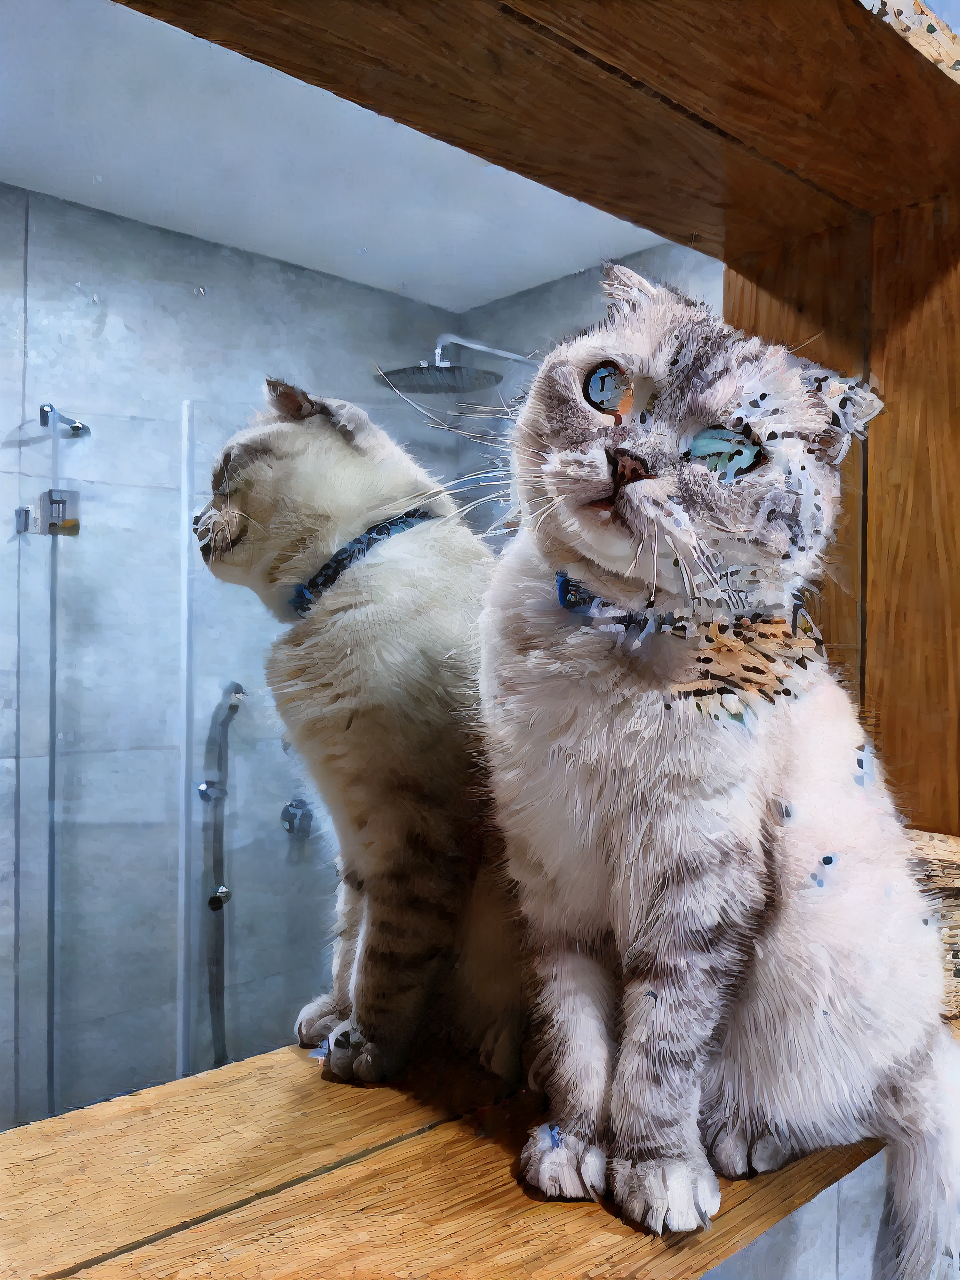

In [250]:
Image.fromarray(edited_images[0])

In [ ]:
import statistics

import scipy  # .stats.ttest_ind
from tqdm import tqdm


preprocess = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        # transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def generative_classification_clark(
    model: StableDiffusionImg2ImgPipeline,
    image: Image.Image,
    classes: List[str],
    num_inference_steps: int = 500,
    min_scores: int = 20,
    max_scores: int = 2000,
    cutoff_pval: float = 5e-3,
    g = None,
):
    image = preprocess(image)
    # scheduler = model.scheduler
    
    scores = {_class: [] for _class in classes}
    n = 0
    denoised_images = []
    min_mean = float("inf")
    min_mean_class = None
    pbar = tqdm(total=max_scores)
    while len(scores) > 1 and n < max_scores:
        n += 1
        pbar.update(1)
        
        # Noise the image by sampling t ~ U[0,1] then generating x_t ~ q(x_t|x)
        # t = torch.randint(200, 201, (1,))  # 1, scheduler.num_train_timesteps, (1,))
        # noise = torch.randn(image.shape, generator=g)
        # noisy_image = scheduler.add_noise(image, noise, t).half().unsqueeze(0)
        
        # for _class, score in scores.items():
        # TODO: Text conditioning
        # TODO: Weighting function
        # image_latent = model.vae.encode(noisy_image.cuda()).latent_dist.sample() * model.vae.config.scaling_factor
        # prompt = f"A photo of a {_class}"
        denoised_images = model(
            prompt=[f"A photo of a {c}" for c in classes],
            image=image,
            generator=g,
            strength=0.5,
            num_inference_steps=num_inference_steps,
            output_type="np.array",
        ).images

        for i, (_class, score) in enumerate(scores.items()):
            score.append(int((image.permute(1, 2, 0) - denoised_images[i]).norm()))
            if (class_mean := statistics.mean(score)) < min_mean:
                min_mean = class_mean
                min_mean_class = _class
            
        if n >= min_scores:
            pvals = []
            for _class in list(scores.keys()):
                if _class == min_mean_class:
                    continue
                score = scores[_class]
                x = scipy.stats.ttest_ind(scores[min_mean_class], scores[_class]).pvalue
                pvals.append(x)
                if x < cutoff_pval:
                    del scores[_class]

    pbar.close()

    statistical_significance = len(scores) == 1
    
    return min_mean_class, statistical_significance

In [5]:
label_idxs = [3, 5]
dataset_max_size = 10

idxs = [i for i, (img, _class) in enumerate(dataset) if _class in label_idxs]
idxs = idxs[:min(len(idxs), dataset_max_size)]

filtered_labels = [l for i, l in enumerate(full_labels) if i in label_idxs]
print(filtered_labels)

['cat', 'dog']


In [22]:
g = torch.Generator(device='cpu')
g.manual_seed(42)

preds = []
significance = []
for i in idxs:
    raw_image, _class = dataset[i]
    print()
    pred, significant = generative_classification_clark(
        pipe,
        raw_image,
        filtered_labels,
        num_inference_steps=500,
        g=g,
        min_scores=10,
        max_scores=40,
        cutoff_pval=0.1,
    )
    print(f"Actual class: {full_labels[_class]}, Predicted class: {pred}")
    preds.append(full_labels.index(pred))
    significance.append(significant)

  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.9137254953384399,0.7019608020782471]
  warnings.warn(
/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:675: FutureWarning: You have passed 2 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this wa

Actual class: cat, Predicted class: cat



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.8039215803146362,0.7647058963775635]
  warnings.warn(
100%|█████████████████████████████| 40/40 [09:44<00:00, 14.61s/it]


Actual class: cat, Predicted class: dog



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
 25%|███████▎                     | 10/40 [02:06<06:18, 12.60s/it]


Actual class: cat, Predicted class: dog



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.9843137264251709,0.7098039388656616]
  warnings.warn(
 25%|███████▎                     | 10/40 [01:44<05:14, 10.47s/it]


Actual class: cat, Predicted class: dog



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.7254902124404907]
  warnings.warn(
 62%|██████████████████▏          | 25/40 [04:21<02:37, 10.47s/it]


Actual class: dog, Predicted class: dog



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.9921568632125854,0.8588235378265381]
  warnings.warn(
100%|█████████████████████████████| 40/40 [06:58<00:00, 10.47s/it]


Actual class: cat, Predicted class: cat



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.7803921699523926,0.9686274528503418]
  warnings.warn(
100%|█████████████████████████████| 40/40 [06:59<00:00, 10.48s/it]


Actual class: cat, Predicted class: dog



100%|█████████████████████████████| 40/40 [06:58<00:00, 10.47s/it]


Actual class: cat, Predicted class: dog



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.843137264251709,1.0]
  warnings.warn(
100%|█████████████████████████████| 40/40 [06:58<00:00, 10.47s/it]


Actual class: cat, Predicted class: cat



  0%|                                      | 0/40 [00:00<?, ?it/s]/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/diffusers/image_processor.py:540: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.9921568632125854]
  warnings.warn(
100%|█████████████████████████████| 40/40 [06:58<00:00, 10.46s/it]

Actual class: dog, Predicted class: dog


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

labels = [dataset[i][1] for i in idxs]
print("Confusion Matrix")
print(confusion_matrix(preds, labels))
print()
print("Accuracy:", accuracy_score(preds, labels), "\n")
print("Significance:", sum(significance) / len(significance))

Confusion Matrix
[[3 0]
 [5 2]]

Accuracy: 0.5 

Significance: 0.4


In [24]:
from collections import Counter
Counter(labels)

Counter({3: 8, 5: 2})